In [1]:
%matplotlib inline

from copy import deepcopy
from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# Comparing Monte Carlo and Temporal Difference Learning
## The Game
We have five non-terminal states. In each state, we have two deterministic actions, left and right. We want to estimate the value function of the uniform random policy. 
- All episodes start in state C;
- Episodes terminate either on the left or on the right;
- The reward is 0 on all transitions except +1 for terminating on the right.

Note that in this problem, the value has an intuitive meaning. The value of each state is the probability terminating on the right when starting from each state. Under the uniform random policy, the value of the start state is 0.5, that means the probability of terminating with +1 from the center is a half. If we start further to left, the probability of terminating with +1 decreases: and vice versa for the right.

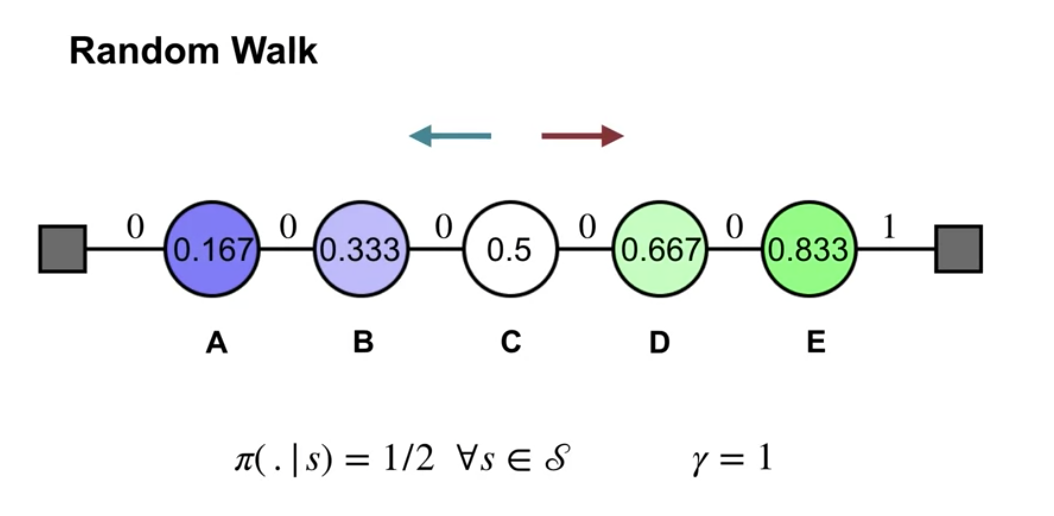

In [2]:
Image("the game.png")

In [3]:
def run_episode():
    
    actions = [-1, 1]  # Left, right
    action_sequence = np.array([])
    
    while True:
        
        # Draw 30 random actions
        seq = np.random.choice(actions, size=30, replace=True)
        action_sequence = np.concatenate([action_sequence, seq], axis=0)
        cumsum = action_sequence.cumsum()
        
        # Cumsum == 3 means right-hand terminal reached
        right_terminal = np.where(cumsum == 3, True, 0)
        end_right_arr = np.argwhere(right_terminal)
        
        # Cumsum == -3 means left-hand terminal reached
        left_terminal = np.where(cumsum == -3, True, 0)
        end_left_arr = np.argwhere(left_terminal)
        
        # Check whether either terminal state has been reached 
        reached_right = end_right_arr.size > 0
        reached_left = end_left_arr.size > 0
        
        if reached_right or reached_left:
            break
        else:
            continue
    
    # Which terminal state?
    if reached_right and reached_left:
        end_right = end_right_arr[0, 0] < end_left_arr[0, 0]

    elif reached_right:
        end_right = True
        
    else:
        end_right = False

    # Allocate reward
    if end_right:
        end_idx = end_right_arr[0, 0] + 1
        sequence = action_sequence[:end_idx]
        reward = np.zeros_like(sequence)
        reward[-1] = 1
        
    else:
        end_idx = end_left_arr[0, 0] + 1
        sequence = action_sequence[:end_idx]
        reward = np.zeros_like(sequence)
        
    states = np.array([3.])  # Start state
    states = np.concatenate([states, sequence.cumsum() + 3], axis=0)
    states = states[:-1]
    
    return states, sequence, reward


## The Agents
- MonteCarlo agents whose state values update at the end of each episode. Some agents apply first-visit logic, whereas others implement every-visit logic.
- Temporal Difference agents that use bootstraping to update state values at each step.

In [4]:
class Agent:

    true_state_values = [0.167, 0.333, 0.5, 0.667, 0.833]

    def __init__(self, gamma=1., alpha=1.):
        state_values = np.zeros(7)  # Initialisation
        state_values[1:-1] = 0.5

        self.state_values = state_values
        self.N = np.zeros(7)
        self.gamma = gamma
        self.alpha = alpha
        self.rmse_log = []

    def log_rmse(self):
        error = self.rmse()
        self.rmse_log.append(error)

    def rmse(self):

        state_values = np.array(self.state_values[1:-1])
        sq_error = (self.true_state_values - state_values) ** 2

        return np.mean(np.sqrt(sq_error))

    def update_state_values(self, episode):
        pass


class MonteCarlo(Agent):

    def __init__(self, gamma=1., alpha=1., first_visit=True):
        super().__init__(gamma, alpha)
        self.first_visit = first_visit

    def update_state_values(self, episode):

        states, actions, rewards = episode
        returns = self.get_returns(episode)
        iterable = tuple(zip(states, returns))

        # only relevant if first_visit=True
        unique = np.unique(states).tolist()
        seen = []

        for i in iterable:
            state, est_return = i

            try:
                assert state not in seen

            except AssertionError:
                continue

            else:
                if self.first_visit:
                    seen.append(state)

            finally:
                idx = int(state)

                self.N[idx] += 1
                step_size = 1 / self.N[idx]

                error = est_return - self.state_values[idx]
                self.state_values[idx] += self.alpha * error

                if self.first_visit and unique == sorted(seen):
                    break

    def get_returns(self, episode):
        returns = []
        s, a, r = episode

        for step in range(len(s)):
            idx = step + 1
            gammas = np.array([self.gamma] * idx)
            powers = np.array([x for x in range(idx)])
            discounted_gammas = gammas ** powers
            rewards = np.array(r[-idx:])
            returns.append(np.sum(discounted_gammas * rewards))

        return returns


class TemporalDifference(Agent):

    def update_state_values(self, episode):

        n_steps = len(episode[1])

        for step in range(n_steps):
            s, a, r = tuple(map(lambda x: x[step], episode))
            idx = int(s)
            next_s_idx = int(idx + a)
            next_s_value = self.state_values[next_s_idx]

            td_error = r + self.gamma * next_s_value - self.state_values[idx]
            self.state_values[idx] += self.alpha * td_error


## Simulations
Each agent will be trained 200 times (epochs) on 100 episodes. The resultant average RMSEs will be compared across agents.

In [5]:
np.random.seed(1)
t0 = time.time()

checkpoints = [9, 49, 99]
error_store = {
    'MCf1': [], 'MCf2': [], 'MCf4': [],
    'MCe1': [], 'MCe2': [], 'MCe4': [],
    'TD05': [], 'TD10': [], 'TD15': []
}
checkpoint_values = {
    'MCf1': [], 'MCf2': [], 'MCf4': [],
    'MCe1': [], 'MCe2': [], 'MCe4': [],
    'TD05': [], 'TD10': [], 'TD15': []
}

# Train the same agent 200 times
for epoch_count in range(200):

    agents = {
        'MCf1': MonteCarlo(alpha=0.01),
        'MCf2': MonteCarlo(alpha=0.02),
        'MCf4': MonteCarlo(alpha=0.04),
        'MCe1': MonteCarlo(alpha=0.01, first_visit=False),
        'MCe2': MonteCarlo(alpha=0.02, first_visit=False),
        'MCe4': MonteCarlo(alpha=0.04, first_visit=False),
        'TD05': TemporalDifference(alpha=0.05),
        'TD10': TemporalDifference(alpha=0.10),
        'TD15': TemporalDifference(alpha=0.15)
    }

    # Train each agent on 100 episodes
    for episode_count in range(100):

        episode = run_episode()

        # Make record of values for plotting
        for name, agent in agents.items():

            agent.update_state_values(episode)
            agent.log_rmse()

            if episode_count == checkpoints[2]:
                error_store[name].append(agent.rmse_log)

            if episode_count in checkpoints and epoch_count == 199:
                cp_values = deepcopy(agent.state_values[1:-1])
                checkpoint_values[name].append(cp_values)

print(f'Solved in {time.time() - t0:.0f} seconds.')

Solved in 19 seconds.


# The results
- Every-visit MC agents seem to outperforms first-visit MC agents for all step-sizes (_alpha_).
- TD agents consistently outperform all MC agents, both in rate of learning an final accuracy. 
- It is possible that MC agents could perform as well as TD agents if we extended the number of episodes to learn from. 
- Increasing the step-size (_alpha_) accelerates the learning in the early episodes in all cases, but inflection points can be found for certain agents whereby it stops learning beyond it. 

In [6]:
for k, v in error_store.items():
    average = np.mean(np.array(v), axis=0)
    error_store[k] = average

In [7]:
colours1 = ['#ff9696','#ff6464','#ff0000']
colours2 = ['#96ff96', '#64ff64', '#32ff32']
colours3 = ['#9696ff', '#6464ff', '#3232ff']
all_cs = colours1 + colours2 + colours3

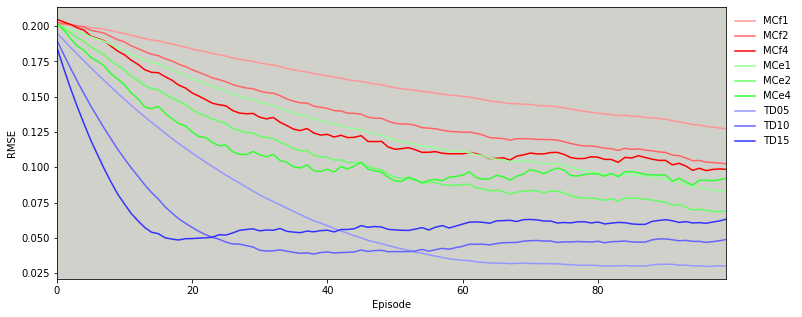

In [8]:
ax = pd.DataFrame.from_dict(error_store).plot(figsize=(12, 5), color=all_cs)
_ = ax.legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
_ = ax.set_ylabel('RMSE')
_ = ax.set_xlabel('Episode')
_ = ax.set_facecolor('#d1d1cb')

## Learning in final epoch

In [9]:
true_values = pd.Series(Agent.true_state_values, index=range(1, 6), name='True Values')

In [10]:
def plot_learning(cp1_vals, cp2_vals, cp3_vals, a1, a2, a3, colours):
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))

    _ = pd.DataFrame(cp1_vals, columns=range(1, 6)).T.plot(color=colours, ax=ax[0])
    _ = ax[0].set_title(f'alpha={a1}, gamma=1.0', loc='left')
    _ = ax[0].set_ylabel('State Values')

    _ = pd.DataFrame(cp2_vals, columns=range(1, 6)).T.plot(color=colours, ax=ax[1])
    _ = ax[1].set_title(f'alpha={a2}, gamma=1.0', loc='left')
    
    _ = pd.DataFrame(cp3_vals, columns=range(1, 6)).T.plot(color=colours, ax=ax[2])
    _ = ax[2].set_title(f'alpha={a3}, gamma=1.0', loc='left')

    for a in ax:
        _ = true_values.plot(ax=a, color='k', linewidth=2, marker='o', alpha=0.7)
        _ = a.legend([f'Episode {cp + 1}' for cp in checkpoints])
        _ = a.set_xlim(0.9, 5.1)
        _ = a.set_xticks(range(1, 6))
        _ = a.set_facecolor('#d1d1cb')

    plt.tight_layout()

First-Visit MonteCarlo Agents:


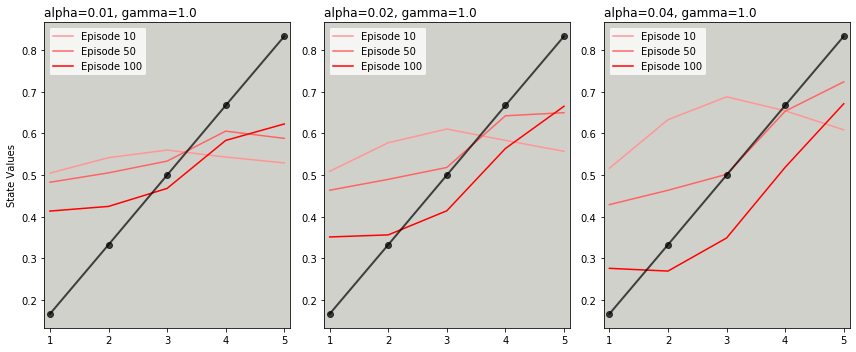

In [11]:
print('First-Visit MonteCarlo Agents:')
plot_learning(checkpoint_values['MCf1'], 
              checkpoint_values['MCf2'], 
              checkpoint_values['MCf4'], 
              '0.01', '0.02', '0.04', colours1)

Every-Visit MonteCarlo Agents:


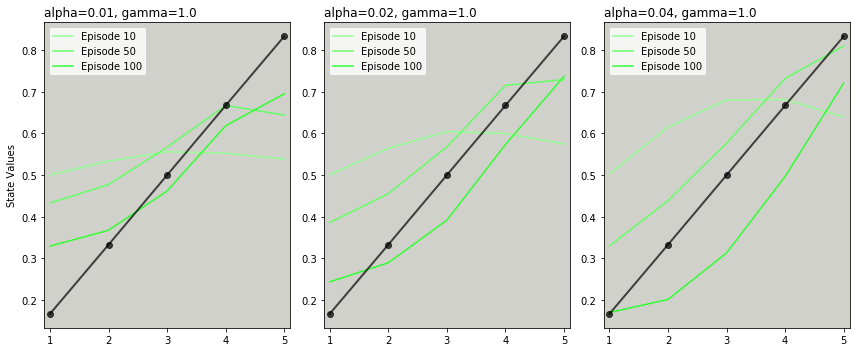

In [12]:
print('Every-Visit MonteCarlo Agents:')
plot_learning(checkpoint_values['MCe1'], 
              checkpoint_values['MCe2'], 
              checkpoint_values['MCe4'], 
              '0.01', '0.02', '0.04', colours2)

Temporal Difference Agents:


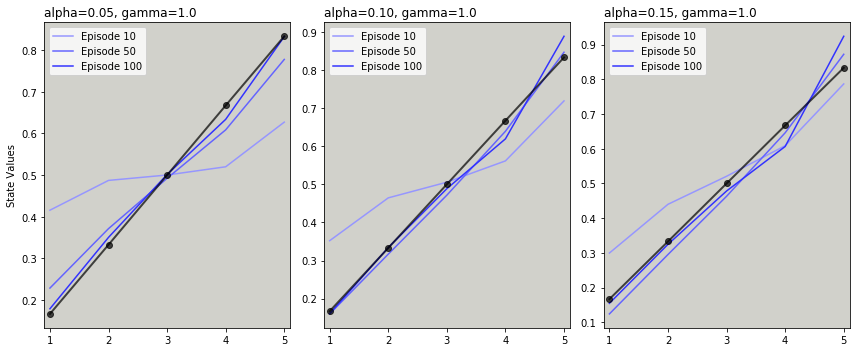

In [13]:
print('Temporal Difference Agents:')
plot_learning(checkpoint_values['TD05'], 
              checkpoint_values['TD10'], 
              checkpoint_values['TD15'], 
              '0.05', '0.10', '0.15', colours3)